# Crime data in Hampshire on March 2019

This data includes a few things including the type of crime, location where it took place (latitude, longitude, LSOA code and name), last outcome category just to mention some of them.

### Challenge: Predict if the accused received any form of punishment.

This information is part of last outcome of the case, under the name of `Last outcome category` in the dataset. The following outcomes are considered as punishment:

- Offender given a caution
- Offender given community sentence
- Offender fined
- Offender given conditional discharge
- Offender sent to prison
- Offender given suspended prison sentence
- Offender ordered to pay compensation 
- Offender deprived of property
- Offender given a drugs possession warning


In this second section, we analyze every feature and its relation with the outcome of the case

In [1]:
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import string
import json

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../data/2019-03-hampshire-street.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13757 entries, 0 to 13756
Data columns (total 12 columns):
Crime ID                 12836 non-null object
Month                    13757 non-null object
Reported by              13757 non-null object
Falls within             13757 non-null object
Longitude                13757 non-null float64
Latitude                 13757 non-null float64
Location                 13757 non-null object
LSOA code                13757 non-null object
LSOA name                13757 non-null object
Crime type               13757 non-null object
Last outcome category    12836 non-null object
Context                  0 non-null float64
dtypes: float64(3), object(9)
memory usage: 1.3+ MB


1. Drop the column `Context` because it's completely empty.
2. Drop the rows with nan values (check that Crime ID, Last outcome have less information than the rest of columns)

In [5]:
df.drop(columns='Context', inplace=True)

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12836 entries, 0 to 13756
Data columns (total 11 columns):
Crime ID                 12836 non-null object
Month                    12836 non-null object
Reported by              12836 non-null object
Falls within             12836 non-null object
Longitude                12836 non-null float64
Latitude                 12836 non-null float64
Location                 12836 non-null object
LSOA code                12836 non-null object
LSOA name                12836 non-null object
Crime type               12836 non-null object
Last outcome category    12836 non-null object
dtypes: float64(2), object(9)
memory usage: 1.2+ MB


Look at the first five rows:

In [7]:
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
0,1edc0409a584e44e41914d2997bdbdd43614ca889b5199...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-0.650636,50.793666,On or near Ferring Gardens,E01031421,Arun 015E,Violence and sexual offences,Status update unavailable
1,4a7fbc063a0515d44ca605dc05cedcc487032aef6db481...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-0.650636,50.793666,On or near Ferring Gardens,E01031421,Arun 015E,Violence and sexual offences,Status update unavailable
2,4b7781de32fc30b4a5f78720f47aa5b89c216967039eee...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.144842,51.350275,On or near Denmead Road,E01022553,Basingstoke and Deane 001A,Burglary,Investigation complete; no suspect identified
3,8dfe557629cfd86e61d8b9fd5d4381b17a5fd63464092b...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.145593,51.354669,On or near Silverdale Road,E01022553,Basingstoke and Deane 001A,Violence and sexual offences,Unable to prosecute suspect
4,f67410fb5f97ede46d0a6b1500ebcb4fb8085366df48de...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.155230,51.353821,On or near Huntsmoor Road,E01022554,Basingstoke and Deane 001B,Criminal damage and arson,Investigation complete; no suspect identified


All of those crimes happened on March. Therefore, the column `Month` doesn't offer additional information. Latitude and Longitude are interesting data for mapping the crimes, as we did in the first section using the polygonal information associated with LSOA codes. Let's use `Location`, `LSOA code` or `LSOA name` (not both, because they are dependent and that's an undesirable condition on predictive modeling) and `Crime type`. As a binary classification problem, the question is if the crime received any kind of punishment, not the nature of the outcome. Also, we have a list of outcomes that are considered as punishment. 

The next step is defining the label `punishment`. We looks for the keywords of the list on the column `Last outcome category` to determine if the outome is a punishment, it means, 1 or not (0).

Firstly, we inspect the possible outcomes on the data:

In [8]:
outcome_list = df['Last outcome category'].unique()
outcome_list

array(['Status update unavailable',
       'Investigation complete; no suspect identified',
       'Unable to prosecute suspect', 'Awaiting court outcome',
       'Local resolution', 'Court result unavailable',
       'Formal action is not in the public interest',
       'Offender given a caution',
       'Action to be taken by another organisation',
       'Court case unable to proceed',
       'Offender given community sentence',
       'Offender ordered to pay compensation',
       'Offender given suspended prison sentence',
       'Offender given conditional discharge', 'Offender fined',
       'Offender sent to prison',
       'Suspect charged as part of another case',
       'Defendant found not guilty', 'Offender deprived of property',
       'Offender given a drugs possession warning',
       'Offender otherwise dealt with', 'Defendant sent to Crown Court'],
      dtype=object)

Two alternatives to label the outomes:

1. Determine if every outcome is in a pre-defined list of punishments. This is the easiest option, but what if the outcome doesn't match perfectly with the pre-defined outcomes? An extra (or lack of) space or special character is all you need to ruin the detection. It motivates the use of another choice.
2. Create a dictionary of punishments words and determine if some expressions in the outcome words belong to the dictionary.

In [9]:
dist_outcomes = df.groupby('Last outcome category').count().reset_index().rename(columns={'Crime ID': 'number_cases'}).loc[:, ['Last outcome category', 'number_cases']]
dist_outcomes.sort_values(by=['number_cases'], ascending=False, inplace=True)

In [10]:
dist_outcomes

,Last outcome category,number_cases
7,Investigation complete; no suspect identified,5120
21,Unable to prosecute suspect,4475
19,Status update unavailable,1258
3,Court result unavailable,567
8,Local resolution,469
1,Awaiting court outcome,311
6,Formal action is not in the public interest,180
11,Offender given a caution,175
0,Action to be taken by another organisation,82
13,Offender given community sentence,58


In [11]:
dist_outcomes['% total cases'] = (dist_outcomes['number_cases']/dist_outcomes.number_cases.sum())*100
dist_outcomes

,Last outcome category,number_cases,% total cases
7,Investigation complete; no suspect identified,5120,39.887816
21,Unable to prosecute suspect,4475,34.862886
19,Status update unavailable,1258,9.800561
3,Court result unavailable,567,4.417264
8,Local resolution,469,3.653786
1,Awaiting court outcome,311,2.422873
6,Formal action is not in the public interest,180,1.402306
11,Offender given a caution,175,1.363353
0,Action to be taken by another organisation,82,0.638828
13,Offender given community sentence,58,0.451854


Additionally, we delete the following categories

- Awaiting court outcome
- Court result unavailable
- Status update unavailable
- Defendant sent to Crown Court
- Formal action is not in the public interest
- Local resolution

The binary classification problem that we are trying to resolve if about if the cases have a punishment or not and the categories below don't give more information about that.

In [12]:
df = df[(df['Last outcome category'] != 'Awaiting court outcome') & 
        (df['Last outcome category'] != 'Court result unavailable') &
        (df['Last outcome category'] != 'Status update unavailable') &
        (df['Last outcome category'] != 'Defendant sent to Crown Court') &
        (df['Last outcome category'] != 'Formal action is not in the public interest') &
        (df['Last outcome category'] != 'Local resolution')]

Importing **nltk** tools as the default list of stopwords in English language and the tokenization of words into a sentences:

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Inspecting the list of outcomes that we must consider as punishments:

- The word **offender** is in all the outcomes that classify as punishments.
- The same word, **offender** is additionally in the outcome **Offender otherwise dealt with** that is not a punishment.

Under that scenario, the **punishment list** is defined using the below conditions:

In [14]:
punishments = []
for outcome in outcome_list:
    tokens = word_tokenize(outcome)
    if 'Offender' in tokens and 'otherwise' not in tokens:
        punishments.append(outcome)

Displaying the list:

In [15]:
punishments

['Offender given a caution',
 'Offender given community sentence',
 'Offender ordered to pay compensation',
 'Offender given suspended prison sentence',
 'Offender given conditional discharge',
 'Offender fined',
 'Offender sent to prison',
 'Offender deprived of property',
 'Offender given a drugs possession warning']

The punishment list is used to create the set of **punishment keywords**, applying stemming and deletion of stop words.

In [16]:
stopwords = set(stopwords.words('english'))

In [17]:
keywords = [word.lower() for punishment in punishments for word in word_tokenize(punishment) if word not in stopwords]

Displaying the punishment keyword:

In [18]:
punish_keywords = set(keywords)
punish_keywords

{'caution',
 'community',
 'compensation',
 'conditional',
 'deprived',
 'discharge',
 'drugs',
 'fined',
 'given',
 'offender',
 'ordered',
 'pay',
 'possession',
 'prison',
 'property',
 'sent',
 'sentence',
 'suspended',
 'warning'}

Then, we remove the special characters or punctuation and finally, every word is reduced to his root through **stemming**, for being able to match wrongly tiped words.

In information retrieval, stemming is the process of reducing inflected words to their word stem, base or root form. The proposal is map words to the same stem, which is not necessarily identified with a morphological valid root.

In [19]:
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
stemmer = nltk.stem.porter.PorterStemmer()

Displaying the list of punishment stems:

In [20]:
punish_stems = [stemmer.stem(word.translate(remove_punct_dict)) for word in punish_keywords]

In [21]:
punish_stems

['possess',
 'properti',
 'commun',
 'depriv',
 'prison',
 'condit',
 'compens',
 'fine',
 'sent',
 'caution',
 'pay',
 'warn',
 'order',
 'discharg',
 'offend',
 'sentenc',
 'drug',
 'given',
 'suspend']

Defining the `classify_punishment` function to determine if the outcome correspond to an effective punishment or not:

In [22]:
def classify_punishment(outcome):
    word_list = [word.lower() for word in word_tokenize(outcome)]
    outcome_set = set([stemmer.stem(word.translate(remove_punct_dict)) for word in word_list])
    coincidence = len(outcome_set.intersection(punish_stems))
    if coincidence >= 2:
        return 1
    else:
        return 0

Applying the method to the dataset, the results are stored in the column `punishment`:

In [23]:
df['punishment'] = df['Last outcome category'].apply(classify_punishment)

In [24]:
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,punishment
2,4b7781de32fc30b4a5f78720f47aa5b89c216967039eee...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.144842,51.350275,On or near Denmead Road,E01022553,Basingstoke and Deane 001A,Burglary,Investigation complete; no suspect identified,0
3,8dfe557629cfd86e61d8b9fd5d4381b17a5fd63464092b...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.145593,51.354669,On or near Silverdale Road,E01022553,Basingstoke and Deane 001A,Violence and sexual offences,Unable to prosecute suspect,0
4,f67410fb5f97ede46d0a6b1500ebcb4fb8085366df48de...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.155230,51.353821,On or near Huntsmoor Road,E01022554,Basingstoke and Deane 001B,Criminal damage and arson,Investigation complete; no suspect identified,0
5,3f2fb3cbac2e13d1be9cdc3a8c3f0f34d6988b180f3459...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.157668,51.354819,On or near Wigmore Road,E01022554,Basingstoke and Deane 001B,Criminal damage and arson,Investigation complete; no suspect identified,0
6,a75c95f95d0db3ecb0f9fc55feb0d28aeb319735941e2c...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.166627,51.354901,On or near Ash Lane,E01022554,Basingstoke and Deane 001B,Other theft,Investigation complete; no suspect identified,0


In [25]:
df[df.punishment == 1].head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,punishment
78,14fec825996b563291dc971e8c4adbf026ea5dfadb82e7...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.335400,51.346718,On or near Pound Lane,E01022489,Basingstoke and Deane 003B,Violence and sexual offences,Offender given a caution,1
148,2acb8489189c01d7ee48275de61349eba6914a9b41ba46...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.049255,51.301467,On or near Rowner Crescent,E01022496,Basingstoke and Deane 006B,Violence and sexual offences,Offender given a caution,1
228,7d381892579a89a8d92d412eca573a5774ec4fca5bbc7f...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.098325,51.281066,On or near Tintern Close,E01022543,Basingstoke and Deane 007F,Violence and sexual offences,Offender given a caution,1
338,f558e324e68a6cb3dbd9190ba395785c51b904ddec5cea...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.078904,51.276410,On or near Coleman Close,E01022523,Basingstoke and Deane 008D,Violence and sexual offences,Offender given a caution,1
487,5b196880152653518c2dc40359ebfb9cb02543a987232c...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.073094,51.256644,On or near Renoir Close,E01022506,Basingstoke and Deane 011C,Violence and sexual offences,Offender given a caution,1


### 1. Distribution of effective punishment

In [26]:
dist_punishment = df.groupby('punishment').count().reset_index().rename(columns={'Crime ID': 'number_crimes'}).loc[:, ['number_crimes', 'punishment']]
dist_punishment

,number_crimes,punishment
0,9712,0
1,338,1


In [27]:
dist_punishment['% total crimes'] = (dist_punishment.number_crimes/dist_punishment.number_crimes.sum())*100
dist_punishment

,number_crimes,punishment,% total crimes
0,9712,0,96.636816
1,338,1,3.363184


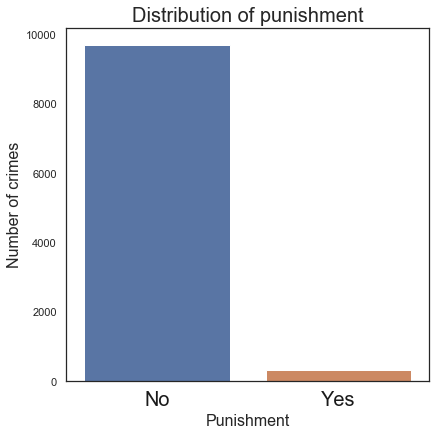

In [28]:
sns.set(style='white')

_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x='punishment', y='number_crimes', data=dist_punishment)
_ = plt.title('Distribution of punishment', size=20)
_ = plt.xticks((0, 1), ('No', 'Yes'), color='k', size=20)
_ = plt.xlabel('Punishment', size=16)
_ = plt.ylabel('Number of crimes', size=16)

Only the 3.36% of the cases have an effective punishment. Clearly, we are facing an unbalanced classification problem.

### 2. Types of crimes

In [29]:
dist_crimes = df.groupby('Crime type').count().reset_index().rename(columns={'Crime ID': 'number_crimes'}).loc[:, ['Crime type', 'number_crimes']]
dist_crimes.sort_values(by=['number_crimes'], ascending=False, inplace=True)

In [30]:
dist_crimes

,Crime type,number_crimes
12,Violence and sexual offences,3895
2,Criminal damage and arson,1284
7,Public order,949
5,Other theft,899
1,Burglary,832
11,Vehicle crime,809
9,Shoplifting,715
0,Bicycle theft,219
4,Other crime,119
8,Robbery,87


In [31]:
dist_crimes['% total crimes'] = (dist_crimes['number_crimes']/dist_crimes.number_crimes.sum())*100
dist_crimes

,Crime type,number_crimes,% total crimes
12,Violence and sexual offences,3895,38.756219
2,Criminal damage and arson,1284,12.776119
7,Public order,949,9.442786
5,Other theft,899,8.945274
1,Burglary,832,8.278607
11,Vehicle crime,809,8.049751
9,Shoplifting,715,7.114428
0,Bicycle theft,219,2.179104
4,Other crime,119,1.184080
8,Robbery,87,0.865672


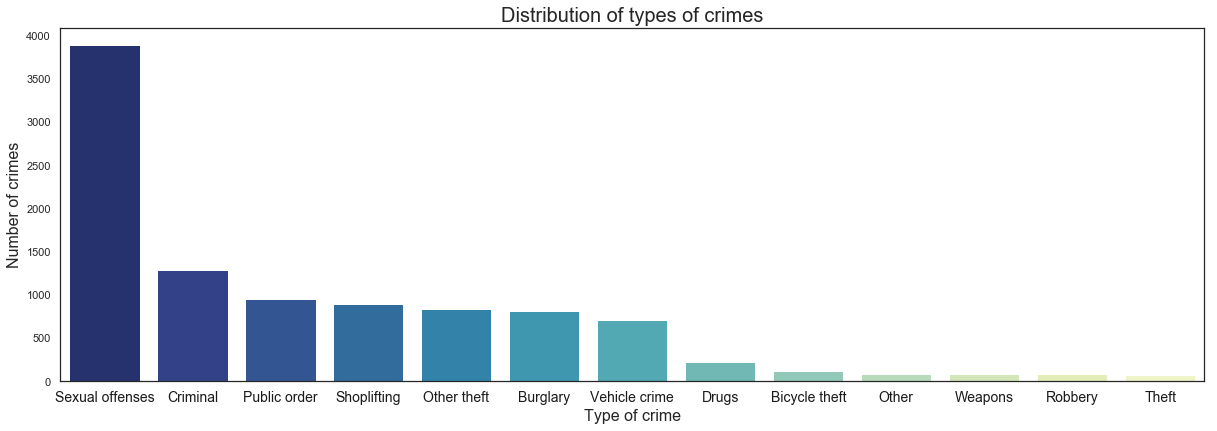

In [32]:
sns.set(style='white')

_ = plt.figure(figsize=(20.5, 6.5))
_ = sns.barplot(x='Crime type', y='number_crimes', data=dist_crimes, palette='YlGnBu_r')
_ = plt.title('Distribution of types of crimes', size=20)
_ = plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), 
               ('Sexual offenses', 
                'Criminal',
                'Public order',
                'Shoplifting',
                'Other theft',
                'Burglary',
                'Vehicle crime',
                'Drugs',
                'Bicycle theft',
                'Other',
                'Weapons',
                'Robbery',  
                'Theft'
                ), color='k', size=14)
_ = plt.xlabel('Type of crime', size=16)
_ = plt.ylabel('Number of crimes', size=16)

38.75% of cases are related to violence and sexual offense, followed by 12.77% of cases about criminal damage and arson. Then, 9.44% are related to public disorder. Shoplifting, thefts, robberies are in different categories. How mauch different are the sentences depending on the type of case?

According to the [UK Sentencing Council](https://www.sentencingcouncil.org.uk/blog/post/what-is-the-difference-between-theft-robbery-and-burglary/), the difference between theft, robbery and burglary are the following:

In legislation 'a person is guilty of **theft** if he dishonestly appropriates property belonging to another with the intention of permanently depriving the other of it.' This could mean someone stealing from a shop, picking someone’s pocket, stealing a bicycle or car, an employee stealing from their workplace or a guest stealing something from a house during a party. The **maximum sentence for theft is seven years**.

The definition of robbery is: 'A person is guilty of robbery if he steals, and immediately before or at the time of doing so, and in order to do so, he uses force on any person or puts or seeks to put any person of being then and there subjected to force'. This can include a street mugging or robbery of a shop, business or security vehicle. Robbery has a violent nature and **because this is more serious than *theft*, the maximum sentence is life.**

There are **three types of burglary** recognised in law:

#### 1. Domestic burglary – Burglary of a dwelling

This type of burglary occurs when an offender enters, as per the definition above, a building which people live in. This generally refers to houses or flats. It also includes boats and vehicles in which people live, such as caravans, and can include domestic outhouses or garages if they are linked to a house. The maximum sentence is 14 years.

#### 2. Non-domestic burglary – Burglary of premises other than a dwelling – **Shoplifting**

This type of burglary relates to buildings which are not lived in, such as shops or offices.
The maximum sentence is 10 years.

Burglary can be committed when a person is permitted to enter a home or other premises but then goes to a room or area where they are not permitted to be and steals something.  For example, if person steals from items on display in a shop that would be theft, but if they go into a storeroom and steal something, that would be burglary.

#### 3. Aggravated burglary

This offence is committed when, at the time of a burglary, the offender has with him any firearm or imitation firearm, any weapon of offence or any explosive.

Where a weapon is used to attack someone at the property in the course of the burglary the offender would also normally be charged with an assault offence, or alternatively they could be charged with robbery. The maximum sentence for aggravated burglary is life.

### 3. Crime and punishment

*"What do you think, would not one tiny crime be wiped out by thousands of good deeds?"* (Crime and Punishment, 1866).

Dostoievky said in Crime and punishment, which is one of his masterpieces and it is considered the first great novel of his "mature" period of writing, that *"a hundred suspicions don't make a proof"*. Certainly, some cases take more time of investigation and analysis before they get the proofs that are required to stablish level and type of punishment. If the proofs are unavailable, the cases finish with the following style of outcome: **Investigation complete; no suspect identified**,**Unable to prosecute suspect**, **Court case unable to proceed** as some examples that we found on this dataset.  Let's inspect which kind of crimes are associated with more effective punishments.

In [33]:
dist_crimesPunish = df.groupby(['Crime type', 'punishment']).count().reset_index().rename(columns={'Crime ID': 'number_crimes'}).loc[:, ['Crime type', 'number_crimes', 'punishment']]
dist_crimesPunish.sort_values(by=['Crime type', 'punishment'], inplace=True)

In [34]:
dist_crimesPunish

,Crime type,number_crimes,punishment
0,Bicycle theft,217,0
1,Bicycle theft,2,1
2,Burglary,830,0
3,Burglary,2,1
4,Criminal damage and arson,1238,0
5,Criminal damage and arson,46,1
6,Drugs,34,0
7,Drugs,45,1
8,Other crime,116,0
9,Other crime,3,1


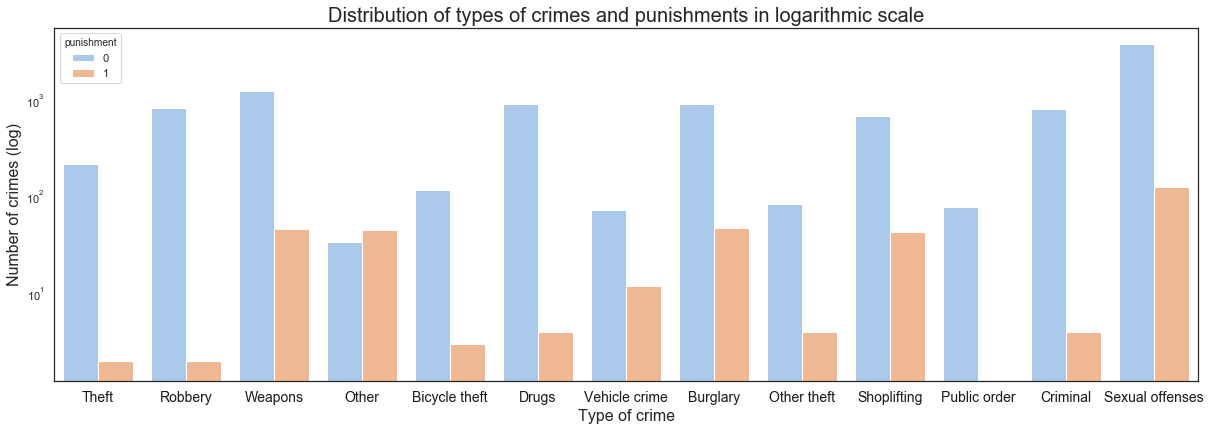

In [35]:
sns.set(style='white')

_ = plt.figure(figsize=(20.5, 6.5))
_ = plt.yscale('log')
_ = sns.barplot(x='Crime type', y='number_crimes', hue='punishment', data=dist_crimesPunish, palette='pastel')
_ = plt.title('Distribution of types of crimes and punishments in logarithmic scale', size=20)
_ = plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), 
               ('Theft', 
                'Robbery', 
                'Weapons', 
                'Other', 
                'Bicycle theft', 
                'Drugs', 
                'Vehicle crime', 
                'Burglary', 
                'Other theft', 
                'Shoplifting', 
                'Public order',
                'Criminal', 
                'Sexual offenses'), color='k', size=14)
_ = plt.xlabel('Type of crime', size=16)
_ = plt.ylabel('Number of crimes (log)', size=16)

Comparing the type of crimes and how many of them have an effective sentence, we observe that cases related to **weapons, burglaries, shoplifting and violence and sexual offenses** have between 10 and 100 cases with enough proofs to declare a sentence.

### Predictive Modeling

#### Selection of features

As we mentioned early, we'll use `Location`, `LSOA name` and `Crime type` to resolve the binary classification problem about the punishment of the crime. 

In [36]:
df_modeling = df.loc[:, ['Location', 'LSOA name', 'Crime type', 'punishment']]

In [37]:
df_modeling.head()

,Location,LSOA name,Crime type,punishment
2,On or near Denmead Road,Basingstoke and Deane 001A,Burglary,0
3,On or near Silverdale Road,Basingstoke and Deane 001A,Violence and sexual offences,0
4,On or near Huntsmoor Road,Basingstoke and Deane 001B,Criminal damage and arson,0
5,On or near Wigmore Road,Basingstoke and Deane 001B,Criminal damage and arson,0
6,On or near Ash Lane,Basingstoke and Deane 001B,Other theft,0


1000 samples are randomly choosen from the negative punishment, as `df_unguilty`. The positive punishments correspond to `df_guilty` and finally both subsets are concatenated in `df_guilt`:

In [38]:
df_unguilty = df_modeling[df_modeling.punishment == 0].sample(1000, random_state=0)
df_guilty = df_modeling[df_modeling.punishment == 1]

In [39]:
df_guilt = pd.concat([df_guilty, df_unguilty])

In [40]:
df_guilt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 78 to 6199
Data columns (total 4 columns):
Location      1338 non-null object
LSOA name     1338 non-null object
Crime type    1338 non-null object
punishment    1338 non-null int64
dtypes: int64(1), object(3)
memory usage: 52.3+ KB


In [41]:
df_guilt.groupby('punishment').count()/len(df_guilt)

,Location,LSOA name,Crime type
punishment,,,
0,0.747384,0.747384,0.747384
1,0.252616,0.252616,0.252616


#### Transforming categorical data

In [42]:
location = pd.get_dummies(df_guilt['Location'], prefix='Location')
lsoa = pd.get_dummies(df_guilt['LSOA name'], prefix='LSOA name')
crime = pd.get_dummies(df_guilt['Crime type'], prefix='Crime type')

In [43]:
data = location.join(lsoa)
data = data.join(crime)

In [44]:
data.head()

,Location_On or near A2030,Location_On or near A3020,Location_On or near A3023,Location_On or near A3057,Location_On or near A3093,Location_On or near A33,Location_On or near Abbeydore Road,Location_On or near Acorn Close,Location_On or near Acre Path,Location_On or near Adams Way,...,Crime type_Drugs,Crime type_Other crime,Crime type_Other theft,Crime type_Possession of weapons,Crime type_Public order,Crime type_Robbery,Crime type_Shoplifting,Crime type_Theft from the person,Crime type_Vehicle crime,Crime type_Violence and sexual offences
78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [45]:
data.columns

Index(['Location_On or near A2030', 'Location_On or near A3020',
       'Location_On or near A3023', 'Location_On or near A3057',
       'Location_On or near A3093', 'Location_On or near A33',
       'Location_On or near Abbeydore Road', 'Location_On or near Acorn Close',
       'Location_On or near Acre Path', 'Location_On or near Adams Way',
       ...
       'Crime type_Drugs', 'Crime type_Other crime', 'Crime type_Other theft',
       'Crime type_Possession of weapons', 'Crime type_Public order',
       'Crime type_Robbery', 'Crime type_Shoplifting',
       'Crime type_Theft from the person', 'Crime type_Vehicle crime',
       'Crime type_Violence and sexual offences'],
      dtype='object', length=1519)

#### Over sampling using SMOTE

As we checked before, 74.7% of data belongs to the same category. In that unbalanced scenario, we use [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) for oversampling the category with less information. The simplest approach to face unbalance data consists in duplicating examples in the minority class (it means that those new examples don't add new information to the model), but instead, new examples can be *synthetized* from the data. In other words, we apply *data augmentation* for the minority class or Synthetic Minority Oversampling Technique, SMOTE.

**SMOTE** selects random example from the minority class and choose one of his K nearest neighbors (typically k=5) in the feature space and a synthetic example is created in a random point of the line between both examples.

**Borderline-SMOTE** is an extension that allows to select those instances of the minority class that are misclassified with a KNN classification model. To do that, we oversample the difficult features, improving the resolution where it is required.

In [46]:
import sys

!{sys.executable} -m pip install imbalanced-learn

In [47]:
y = df_guilt.punishment
X = data

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
columns = X_train.columns

Import SMOTE and BorderlineSMOTE and synthetize as examples as required to complete one thousand of positive punishments:

In [50]:
from imblearn.over_sampling import SMOTE

over = SMOTE()

X_smote, y_smote = over.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_smote))

smote_data_X = pd.DataFrame(data=X_smote, columns=columns)
smote_data_y= pd.DataFrame(data=y_smote)

Using TensorFlow backend.


Resampled dataset shape Counter({1: 1000, 0: 1000})


In [51]:
from imblearn.over_sampling import BorderlineSMOTE

sm = BorderlineSMOTE(random_state=42)
X_border, y_border = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_border))

border_data_X = pd.DataFrame(data=X_border, columns=columns)
border_data_y= pd.DataFrame(data=y_border)

Resampled dataset shape Counter({1: 1000, 0: 1000})


#### Training the Logistic Regression Model using SMOTE and BorderlineSMOTE

And finally, we train our Logistic Regression Model, using the default parameters.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(smote_data_X, smote_data_y, test_size=0.3, random_state=0)
X_train_br, X_test_br, y_train_br, y_test_br = train_test_split(border_data_X,  border_data_y, test_size=0.3, random_state=0)

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
logreg_br = LogisticRegression()
logreg_br.fit(X_train_br, y_train_br)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Evaluating the model

To following, we evaluate the model using **accuracy**, **confusion matrix** and the classification report tool of sklearn that includes **recall** and **F1 score**.

In [55]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set using SMOTE: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set using SMOTE: 0.83


In [56]:
y_pred_br = logreg_br.predict(X_test_br)
print('Accuracy of logistic regression classifier on test set using BorderlineSMOTE: {:.2f}'.format(logreg_br.score(X_test_br, y_test_br)))

Accuracy of logistic regression classifier on test set using BorderlineSMOTE: 0.84


In [57]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[282  14]
 [ 85 219]]


In [58]:
cm_br = confusion_matrix(y_test_br, y_pred_br)
print(cm_br)

[[284  12]
 [ 84 220]]


In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       296
           1       0.94      0.72      0.82       304

    accuracy                           0.83       600
   macro avg       0.85      0.84      0.83       600
weighted avg       0.86      0.83      0.83       600



In [60]:
print(classification_report(y_test_br, y_pred_br))

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       296
           1       0.95      0.72      0.82       304

    accuracy                           0.84       600
   macro avg       0.86      0.84      0.84       600
weighted avg       0.86      0.84      0.84       600



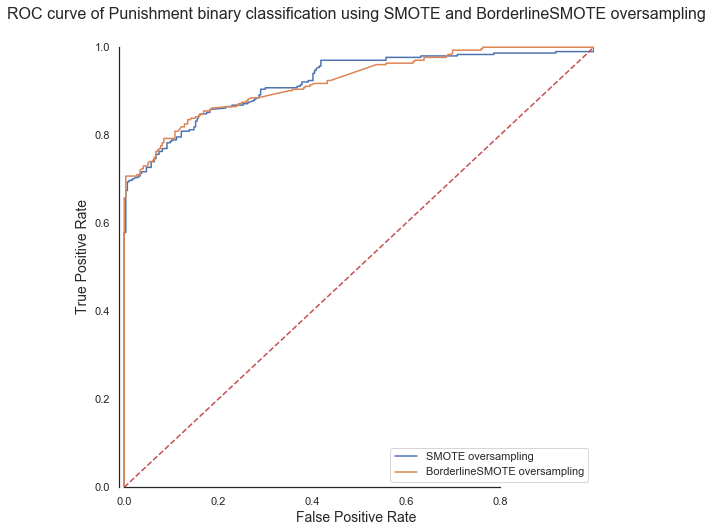

In [61]:
logit_roc_auc_SMOTE = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

logit_roc_auc_borderlineSMOTE = roc_auc_score(y_test_br, logreg_br.predict(X_test_br))
fpr_br, tpr_br, thresholds_br = roc_curve(y_test_br, logreg_br.predict_proba(X_test_br)[:,1])

_ = plt.figure(figsize=(8.5, 8.5))
_ = plt.plot(fpr, tpr, label='SMOTE oversampling')
_ = plt.plot(fpr_br, tpr_br, label='BorderlineSMOTE oversampling')
_ = plt.plot([0, 1], [0, 1],'r--')
_ = plt.xlim([-0.01, 1.0])
_ = plt.ylim([0.0, 1.05])
_ = plt.xlabel('False Positive Rate', size=14)
_ = plt.ylabel('True Positive Rate', size=14)
_ = plt.title('ROC curve of Punishment binary classification using SMOTE and BorderlineSMOTE oversampling', size=16)
_ = sns.despine(trim=True, left=False)
_ = plt.legend(loc='lower right')
_ = plt.show()

In [62]:
print('AUC SMOTE: {:.2f}'.format(logit_roc_auc_SMOTE))
print('AUC BorderlineSMOTE: {:.2f}'.format(logit_roc_auc_borderlineSMOTE))

AUC SMOTE: 0.84
AUC BorderlineSMOTE: 0.84
